In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_449044/388590871.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import seaborn as sns

# Selection model

### Data prep

In [31]:
words = pd.read_csv('./data/words.csv')

In [32]:
# Prepare a model for the finger offset when tapping different keys
offset_keys = pd.read_csv('./data/key_offset.csv', index_col=0)
def get_offset(x):
    effort = 0
    for c in x:
        if c in offset_keys.index:
            effort += offset_keys.loc[c, 'offset_one_thumb']
    return effort

In [33]:
mask = words.ite.isin(['none', 'predict'])
mask &= words.word_length > 1
mask &= words.word_length < 14
mask &= (words.word == words.ite_input) | (words.ite == 'none') # Only words which are the same as the input
data = words.loc[mask, ['word', 'word_length', 'freq', 'ite2', 'iki', 'type', 'ite_input_prev']].copy()

# Add features
data['leadup_length'] = data.word_length # When no ite is used, the leadup length is just the length of the word
data.loc[data.ite2.notna(), 'leadup_length'] = data.ite_input_prev.str.len() # When an ite is used, the leadup length is based on the previous string
data['is_contraction'] = (data.type == 'contraction').astype(float)
data['is_capitalized'] = (data.type == 'proper').astype(float)
data.drop('type', axis=1, inplace=True) # Remove the "type" column, we no longer need it
data.drop('ite_input_prev', axis=1, inplace=True) # Remove the "input_prev" column, we no longer need it

# Remove the less common substrategies
data.ite2 = data.ite2.fillna('none') # When no ite is used, mark as "none"
data = data.loc[data.ite2.isin(['completion', 'correction', 'contraction', 'capitalization', 'prediction', 'none'])] # Ignore the uncommon strategies

# Add features that are based on the normally typed instances of the word
data2 = words.loc[words.ite == 'none'].groupby('word').filter(lambda x: x.shape[0] > 20) # Only words that were typed normally more than 20 times
data['base_speed'] = data.word.map(data2.groupby('word').iki_letters.mean()) # Use letter-only speed
data['touch_offset'] = data.word.map(get_offset) / data.word_length # Normalize the offset based on word length
data['backspaces'] = data.word.map(data2.groupby('word').n_backspace.mean())

# Drop any nan
data = data.dropna()

# Rename
data = data.rename(columns={'iki': 'leadup_speed'})

# Transform to get better distributions
data.freq = np.log10(data.freq)
data.leadup_speed = data.leadup_speed.apply(np.reciprocal) * 1000
data.base_speed = data.base_speed.apply(np.reciprocal) * 1000

# Remove outliers
data = data.loc[data.touch_offset < 1].copy()
data = data.loc[data.leadup_speed < 20].copy()

# Finalize
data = data.set_index('word')

In [34]:
data.ite2.value_counts()

ite2
none              1257543
completion          33221
correction          15391
prediction           2561
contraction          1093
capitalization        927
Name: count, dtype: int64

### Training

In [35]:
# Preprocess X
X = data.loc[:,data.columns != 'ite2'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X.is_contraction = data.is_contraction # Go back to binary
X.is_capitalized = data.is_capitalized # Go back to binary

# Preprocess y
y = data['ite2'].copy()

# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=1)

# Add constant
X_train = sm.add_constant(X_train) # TODO: do we want to include this?

In [36]:
params = []
pvalues = []
errors = []
params_disp = []

# For each substrategy, train a binary logistic regression
for i in y_train.sort_values().unique():
    # Check the substrategy, depending on it we will ignore certain columns
    if i == 'prediction':
        c = ['const', 'word_length', 'freq', 'is_contraction', 'is_capitalized', 'base_speed', 'touch_offset', 'backspaces']
    elif i in ['capitalization', 'contraction']:
        c = ['const', 'word_length', 'freq', 'is_contraction', 'is_capitalized', 'base_speed', 'touch_offset', 'backspaces', 'leadup_speed']
    else:    
        c = X_train.columns # All columns
    if i == 'none':
        continue # Remove this line to see the "none" column
    
    # Fit the regression
    model = sm.Logit((y_train == i).astype(float), X_train.loc[:,c])
    results = model.fit(method='lbfgs', maxiter=1000)
    
    # Save the values
    params.append(results.params.to_frame(i))
    pvalues.append(results.pvalues.to_frame(i))
    errors.append(results.bse.to_frame(i))

# Create dataframe
params = pd.concat(params, axis=1, sort=False)
pvalues = pd.concat(pvalues, axis=1, sort=False)
errors = pd.concat(errors, axis=1, sort=False)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99284D-01

At iterate    1    f=  3.13892D-01    |proj g|=  2.68156D-01


 This problem is unconstrained.



At iterate    2    f=  1.10628D-01    |proj g|=  1.02598D-01

At iterate    3    f=  5.66794D-02    |proj g|=  5.24517D-02

At iterate    4    f=  2.87199D-02    |proj g|=  2.49858D-02

At iterate    5    f=  1.60563D-02    |proj g|=  1.24371D-02

At iterate    6    f=  9.61472D-03    |proj g|=  5.05860D-03

At iterate    7    f=  7.14236D-03    |proj g|=  2.52324D-03

At iterate    8    f=  5.76551D-03    |proj g|=  1.18428D-03

At iterate    9    f=  4.87419D-03    |proj g|=  5.58773D-04

At iterate   10    f=  4.10162D-03    |proj g|=  3.65115D-04

At iterate   11    f=  3.89671D-03    |proj g|=  7.74555D-04

At iterate   12    f=  3.65671D-03    |proj g|=  5.66786D-04

At iterate   13    f=  3.53134D-03    |proj g|=  2.85189D-04

At iterate   14    f=  3.42673D-03    |proj g|=  1.60316D-04

At iterate   15    f=  3.38138D-03    |proj g|=  2.37397D-04

At iterate   16    f=  3.36342D-03    |proj g|=  6.84144D-05

At iterate   17    f=  3.35496D-03    |proj g|=  3.29615D-05

At iter

 This problem is unconstrained.



At iterate    2    f=  1.70215D-01    |proj g|=  8.21599D-02

At iterate    3    f=  9.87893D-02    |proj g|=  3.03366D-02

At iterate    4    f=  8.08369D-02    |proj g|=  2.12868D-02

At iterate    5    f=  4.96276D-02    |proj g|=  1.34609D-02

At iterate    6    f=  3.40582D-02    |proj g|=  7.50528D-03

At iterate    7    f=  2.74728D-02    |proj g|=  1.07972D-02

At iterate    8    f=  2.28172D-02    |proj g|=  1.53364D-03

At iterate    9    f=  2.18790D-02    |proj g|=  8.29270D-04

At iterate   10    f=  2.13319D-02    |proj g|=  1.24680D-03

At iterate   11    f=  2.11126D-02    |proj g|=  4.02854D-04

At iterate   12    f=  2.10410D-02    |proj g|=  3.71462D-04

At iterate   13    f=  2.08778D-02    |proj g|=  3.64677D-04

At iterate   14    f=  2.08570D-02    |proj g|=  3.99654D-04

At iterate   15    f=  2.07957D-02    |proj g|=  2.51911D-04

At iterate   16    f=  2.07879D-02    |proj g|=  1.85414D-04

At iterate   17    f=  2.07849D-02    |proj g|=  8.94109D-05

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.99173D-01

At iterate    1    f=  3.13982D-01    |proj g|=  2.68052D-01

At iterate    2    f=  1.10848D-01    |proj g|=  1.02524D-01

At iterate    3    f=  5.69132D-02    |proj g|=  5.24102D-02

At iterate    4    f=  2.89421D-02    |proj g|=  2.48410D-02

At iterate    5    f=  1.60186D-02    |proj g|=  1.24142D-02

At iterate    6    f=  9.27315D-03    |proj g|=  4.69209D-03

At iterate    7    f=  6.92850D-03    |proj g|=  2.53823D-03

At iterate    8    f=  5.35193D-03    |proj g|=  1.54512D-03

At iterate    9    f=  4.63432D-03    |proj g|=  5.47316D-04

At iterate   10    f=  4.25413D-03    |proj g|=  3.72710D-04

At iterate   11    f=  3.89121D-03    |proj g|=  4.06672D-04

At iterate   12    f=  3.54726D-03    |proj g|=  5.49693D-04

At iterate   13    f=  3.4

 This problem is unconstrained.



At iterate    2    f=  1.40093D-01    |proj g|=  9.54562D-02

At iterate    3    f=  9.11111D-02    |proj g|=  4.95599D-02

At iterate    4    f=  6.67289D-02    |proj g|=  1.77469D-02

At iterate    5    f=  6.10233D-02    |proj g|=  8.49402D-03

At iterate    6    f=  5.70531D-02    |proj g|=  4.57301D-03

At iterate    7    f=  5.43576D-02    |proj g|=  3.65420D-03

At iterate    8    f=  5.26626D-02    |proj g|=  1.15630D-03

At iterate    9    f=  5.24030D-02    |proj g|=  1.06708D-03

At iterate   10    f=  5.22650D-02    |proj g|=  6.56731D-04

At iterate   11    f=  5.22052D-02    |proj g|=  1.30564D-04

At iterate   12    f=  5.21981D-02    |proj g|=  1.21501D-04

At iterate   13    f=  5.21959D-02    |proj g|=  9.99104D-05

At iterate   14    f=  5.21909D-02    |proj g|=  1.29318D-04

At iterate   15    f=  5.21866D-02    |proj g|=  4.42462D-04

At iterate   16    f=  5.21806D-02    |proj g|=  2.62573D-04

At iterate   17    f=  5.21719D-02    |proj g|=  1.22737D-04

At iter

 This problem is unconstrained.



At iterate    2    f=  1.13850D-01    |proj g|=  1.01848D-01

At iterate    3    f=  6.08684D-02    |proj g|=  5.17835D-02

At iterate    4    f=  3.38872D-02    |proj g|=  2.44491D-02

At iterate    5    f=  2.22002D-02    |proj g|=  1.18580D-02

At iterate    6    f=  1.68733D-02    |proj g|=  5.01839D-03

At iterate    7    f=  1.47196D-02    |proj g|=  2.02265D-03

At iterate    8    f=  1.41832D-02    |proj g|=  8.37947D-04

At iterate    9    f=  1.39993D-02    |proj g|=  2.17835D-04

At iterate   10    f=  1.39499D-02    |proj g|=  1.24965D-04

At iterate   11    f=  1.39246D-02    |proj g|=  6.68047D-05

At iterate   12    f=  1.39106D-02    |proj g|=  4.32090D-05

At iterate   13    f=  1.39085D-02    |proj g|=  1.41841D-05

At iterate   14    f=  1.39083D-02    |proj g|=  9.57050D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

### Coefficients

In [37]:
def to_asterix(x):
    if x <= 0.01:
        return '***'
    elif x <= 0.05:
        return '**'
    elif x <= 0.1:
        return '*'
    else:
        return ''

# Create a nice display of the parameters (significance, errors, etc.)
params_disp = pd.DataFrame()
for c in params.columns:
    for i in params.index:
        param = params.loc[i, c]
        p = pvalues.loc[i, c]
        e = errors.loc[i, c]
        if np.isnan(param):
            params_disp.loc[i, c] = 'N/A'
        else:
            params_disp.loc[i, c] = '{}{}\n({})'.format(
                str(round(param, 2)),
                to_asterix(p),
                str(round(e, 2))
            ) 

In [38]:
from IPython.display import display

# Assuming the variable df contains the relevant DataFrame
display(params_disp.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

,capitalization,completion,contraction,correction,prediction
const,-11.14*** (0.17),-8.3*** (0.05),-12.96*** (0.58),-5.87*** (0.02),-6.42*** (0.03)
word_length,0.37*** (0.04),5.58*** (0.03),-0.09 (0.1),0.77*** (0.01),0.53*** (0.04)
freq,-0.61*** (0.07),-0.41*** (0.02),0.2* (0.11),-0.39*** (0.01),0.51*** (0.04)
is_contraction,-0.7 (1.13),0.53*** (0.09),12.14*** (0.61),-1.05*** (0.1),0.01 (0.9)
is_capitalized,5.4*** (0.17),-0.24*** (0.07),-1.44 (10.84),-0.6*** (0.05),-0.08 (0.25)
base_speed,0.53*** (0.05),0.06*** (0.02),-0.13** (0.06),0.12*** (0.01),0.14*** (0.03)
touch_offset,0.08** (0.04),0.04*** (0.01),0.05 (0.06),-0.04*** (0.01),-0.11*** (0.02)
backspaces,-0.0 (0.03),-0.25*** (0.02),-0.2*** (0.03),-0.07*** (0.01),-0.57*** (0.05)
leadup_speed,-1.76*** (0.09),-3.37*** (0.04),0.26*** (0.06),-1.97*** (0.02),N/A
leadup_length,N/A,-5.47*** (0.03),N/A,-0.3*** (0.01),N/A


### What is the performance for estimating the probability of selection?

In [39]:
def predict_prob(params, x):
    # Get odds from params
    odds = (params * x).sum(axis=1).apply(np.exp)
    return odds / (1 + odds)

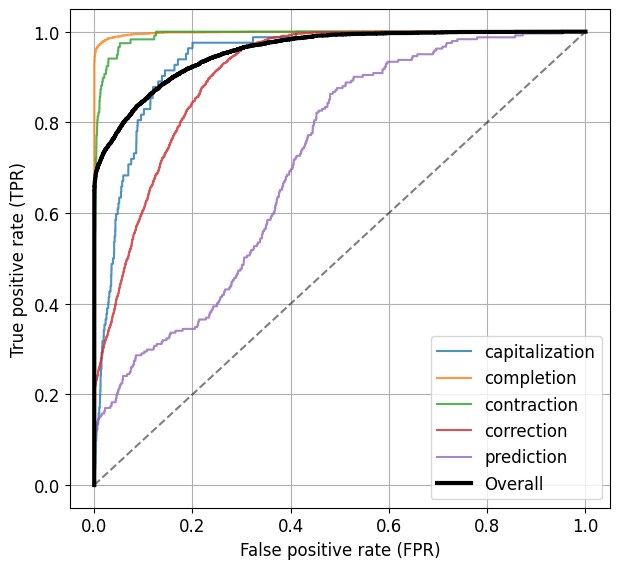

In [40]:
f,ax = plt.subplots(1, 1, figsize=(6, 5.5))

# 1. Calculate performance for each substrategy

for i in params.columns:
    if i == 'none':
        continue
    
    # Prepare X and y for this substrategy
    mask = (y_test == i) | (y_test == 'none') # Remove instances where other substrategies were used
    X_test_s = X_test.loc[mask]
    y_test_s = y_test.loc[mask] != 'none' # Binary: True when the substrategy is used
   
    # Calculate the probability of using the substrategy on a given word
    y_prob = pd.DataFrame(columns=params.columns)
    X_test_s = sm.add_constant(X_test_s)
    for c in params.columns:
        y_prob[c] = predict_prob(params[c], X_test_s)
    y_prob = y_prob.sum(axis=1) # Probability of using suggestions is the sum of the estimated probability for each substrategy

    fpr, tpr, thresh = metrics.roc_curve(y_test_s, y_prob)
    precision, recall, prthresh = metrics.precision_recall_curve(y_test_s, y_prob)

    # Plot ROC
    ax.plot(fpr, tpr, label = i, alpha=0.8)


# 2. Calculate performance for overall performance

y_test_bool = y_test != 'none' # Binary: True if ANY substrategy was used (rather than a specific one)

# Calculate the probability of using the substrategy on a given word
y_prob = pd.DataFrame(columns=params.columns)
X_test = sm.add_constant(X_test)
for c in params.columns:
    y_prob[c] = predict_prob(params[c], X_test)
y_prob = y_prob.sum(axis=1) # Probability of using suggestions is the sum of the estimated probability for each substrategy


fpr, tpr, thresh = metrics.roc_curve(y_test_bool, y_prob)
precision, recall, prthresh = metrics.precision_recall_curve(y_test_bool, y_prob)


# Plot ROC for overall performance
ax.plot(fpr, tpr, label='Overall', lw=3, c='k')
ax.plot([0,1], [0,1], '--', c='k', alpha=0.5)

# 3. Other plot settings
ax.legend(fontsize=12)
ax.grid()
ax.set_xlabel('False positive rate (FPR)')
ax.set_ylabel('True positive rate (TPR)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad = 0)

f.savefig('./figures/roc_selection.png',dpi=300)

In [41]:
roc = pd.DataFrame([fpr, tpr, thresh]).T
roc.columns = ['fpr', 'tpr', 'thresh']
roc = roc.set_index('thresh')
roc.loc[(roc.fpr < 0.1) & (roc.tpr > 0.8)].sample(5, random_state=0)

,fpr,tpr
thresh,,
0.040179,0.095428,0.842969
0.042683,0.087640,0.835909
0.051984,0.064649,0.805953
0.044121,0.083357,0.829994
0.046609,0.076649,0.821790


In [43]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test_bool, y_prob > 0.05))
confusion_matrix

,0,1
0,117176,8657
1,995,4246


In [44]:
metrics.accuracy_score(y_test_bool, y_prob > 0.05)

0.9263622076079161

In [45]:
metrics.precision_score(y_test_bool, y_prob > 0.05)

0.3290707587382779

In [46]:
metrics.recall_score(y_test_bool, y_prob > 0.05)

0.810150734592635